In [2]:
import os
import re
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
llm=ChatGroq(model="qwen/qwen3-32b")
result=llm.invoke("Hi!!!")
raw=result.content

# Remove the <think>...</think> section
cleaned = re.sub(r"<think>.*?</think>\s*", "", raw, flags=re.DOTALL)
cleaned

"Hello! 😊 How are you today? Let me know if there's anything I can help with!"

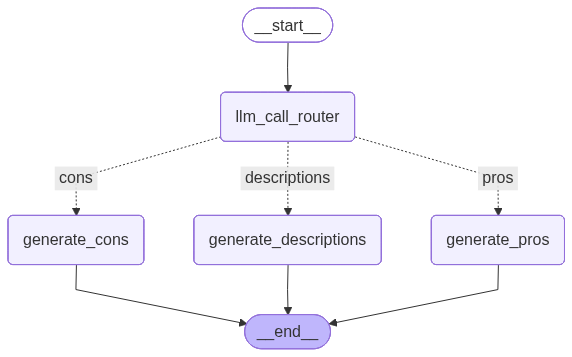

In [7]:
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

class Route(BaseModel):
    step:Literal["descriptions","pros","cons"]=Field(description="The next step in the routing process")

## Augment the LLM with schema for structured output
router=llm.with_structured_output(Route)

class State(TypedDict):
    input:str
    decision:str
    output:str


def generate_descriptions(state: State):
    """Generate descriptions"""
    print("Generating descriptions...")
    msg = llm.invoke(state["input"])
    return {"output": re.sub(r"<think>.*?</think>\s*", "", msg.content, flags=re.DOTALL)}

def generate_pros(state: State):
    """Generate pros"""
    print("Generating pros...")
    msg = llm.invoke(state["input"])
    return {"output": re.sub(r"<think>.*?</think>\s*", "", msg.content, flags=re.DOTALL)}

def generate_cons(state: State):
    """Generate cons"""
    print("Generating cons...")
    msg = llm.invoke(state["input"])
    return {"output": re.sub(r"<think>.*?</think>\s*", "", msg.content, flags=re.DOTALL)}

def llm_call_router(state:State):
    """Route the input to the appropriate node"""

    decision=router.invoke([
        SystemMessage(
            content="Route the input to descriptions,pros or cons based on the users request"
        ),
        HumanMessage(content=state["input"])
    ])
    print("***** Desision*****: ", decision)
    print("Router decision: ", decision.step)
    return {"decision":decision.step}   


def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "descriptions":
        return "descriptions"
    elif state["decision"] == "pros":
        return "pros"
    elif state["decision"] == "cons":
        return "cons"
    
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

router_builder = StateGraph(State)

router_builder.add_node("generate_descriptions", generate_descriptions)
router_builder.add_node("generate_pros", generate_pros)
router_builder.add_node("generate_cons", generate_cons)
router_builder.add_node("llm_call_router", llm_call_router)

router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "descriptions": "generate_descriptions",
        "pros": "generate_pros",
        "cons": "generate_cons",
    },
)
router_builder.add_edge("generate_descriptions", END)
router_builder.add_edge("generate_pros", END)
router_builder.add_edge("generate_cons", END)



# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))



In [9]:
state=router_workflow.invoke({"input":"Give me bad side of AI"})
print(state["output"])

***** Desision*****:  step='cons'
Router decision:  cons
Generating cons...
The development and deployment of artificial intelligence (AI) bring significant benefits, but they also raise critical ethical, societal, and technical concerns. Here are the major **negative aspects** of AI, organized by key challenges:

---

### 1. **Job Displacement and Economic Inequality**
   - **Automation of Labor**: AI can automate repetitive tasks, displacing workers in industries like manufacturing, retail, and customer service. While new jobs may emerge, retraining may not keep pace, leading to short-term unemployment and long-term economic shifts.
   - **Widening Inequality**: AI-driven productivity gains may concentrate wealth among tech companies and shareholders, exacerbating income inequality if benefits are not equitably distributed.

---

### 2. **Bias and Discrimination**
   - **Algorithmic Bias**: AI systems trained on biased data (e.g., historical hiring practices, law enforcement records)

In [10]:
state=router_workflow.invoke({"input":"Give me benifits of Sports"})
print(state["output"])

***** Desision*****:  step='pros'
Router decision:  pros
Generating pros...
Here’s a structured and comprehensive overview of the **benefits of sports**, organized into key categories:

---

### **1. Physical Health Benefits**
- **Cardiovascular Health**: Regular sports activity strengthens the heart, improves circulation, and reduces the risk of heart disease.
- **Muscle and Bone Strength**: Enhances muscle tone, flexibility, and bone density, reducing the risk of osteoporosis.
- **Weight Management**: Burns calories, helps maintain a healthy weight, and combats obesity.
- **Chronic Disease Prevention**: Lowers the risk of diabetes, hypertension, and metabolic syndrome.
- **Motor Skills Development**: Improves coordination, balance, and agility, especially in children.
- **Improved Sleep**: Physical exertion promotes better sleep quality and duration.

---

### **2. Mental and Cognitive Benefits**
- **Stress Reduction**: Releases endorphins, which alleviate stress and anxiety.
- **Men

In [11]:
state=router_workflow.invoke({"input":"Say something about Bangladesh"})
print(state["output"])

***** Desision*****:  step='descriptions'
Router decision:  descriptions
Generating descriptions...
Bangladesh, located in South Asia, is the eighth most populous country globally, with a rich cultural heritage and a complex socio-political landscape. Here's a structured overview:

### **Geography and Population**
- **Location**: Bordered by India to the west, north, and east, and Myanmar to the southeast, with the Bay of Bengal to the south. It sits on the Ganges Delta, making it prone to flooding and cyclones.
- **Capital**: Dhaka, a bustling metropolis and the economic, cultural, and administrative hub.
- **Population**: Over 160 million, predominantly Bengali-speaking with a Muslim majority (~90%), alongside significant Hindu, Buddhist, Christian, and tribal communities.
- **Density**: One of the world's most densely populated countries, with challenges in urban infrastructure.

### **History**
- **Independence**: Gained sovereignty in 1971 after a 9-month Liberation War from Pakis